# Learning about Automatic symbolic MPO construction

## Reference
- [Jiajun Ren, Weitang Li, Tong Jiang, Zhigang Shuai; A general automatic method for optimal construction of matrix product operators using bipartite graph theory. J. Chem. Phys. 28 August 2020; 153 (8): 084118.](https://doi.org/10.1063/5.0018149)


## Import modules

In [1]:
import sympy

from pympo import (
    OpSite,
    SumOfProducts,
    assign_core,
    get_UVE,
    show_assigns,
    show_bipartite,
    show_maximal_matching,
    show_min_vertex_cover,
)

## Define operator

- chose favorite Hamiltonian operator.

1. 1-D Ising model
2. Generalized Henon-Heiles Hamiltonian

In [2]:
Ising = SumOfProducts([])
J = sympy.Symbol("J")
h = sympy.Symbol("h")
ndim = 5
spin_ops = [OpSite(r"\hat{s}" + f"_{i}", i) for i in range(ndim)]
for i in range(ndim - 1):
    Ising += -J * spin_ops[i] * spin_ops[i + 1]
    Ising -= h * spin_ops[i]
Ising += -h * spin_ops[-1]
Ising = Ising.simplify()
print(f"{Ising.ndim=}, {Ising.nops=}")
Ising.symbol

Ising.ndim=5, Ising.nops=9


-J*\hat{s}_0*\hat{s}_1 - J*\hat{s}_1*\hat{s}_2 - J*\hat{s}_2*\hat{s}_3 - J*\hat{s}_3*\hat{s}_4 - h*\hat{s}_0 - h*\hat{s}_1 - h*\hat{s}_2 - h*\hat{s}_3 - h*\hat{s}_4

In [3]:
Hamiltonian = Ising

## Initialze list of assignment information

- `W_assigns` holds which row and column each operator is assigned to on each site.
- `coef_site` holds which site coefficient is multiplied to operator.
- `W` is a generated MPO.

In [4]:
W_assigns: list[list[int]] = [
    [k for _ in range(Hamiltonian.ndim)] for k in range(Hamiltonian.nops)
]
coef_site: list[int] = [Hamiltonian.ndim - 1 for _ in range(Hamiltonian.nops)]
W: list[sympy.Basic] = []

`n` sum-of-product terms can be naively converted to a MPO with bond dimension `M=n`.
The green edges indicate the mulitplication of the coefficient to the operator.

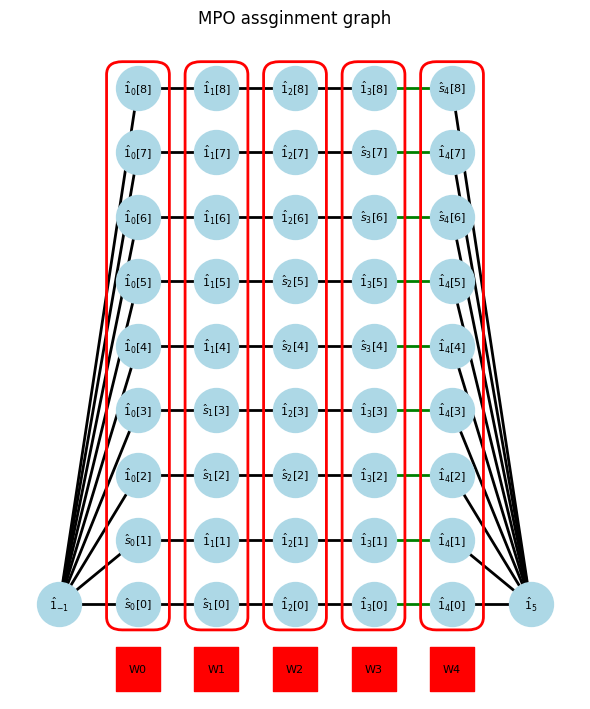

In [5]:
show_assigns(Hamiltonian, W_assigns, coef_site)

At first, we focus on the gap between 0th and 1st site.
The opearator in left blocks and right blocks can be interpreted as a bipartite graph.

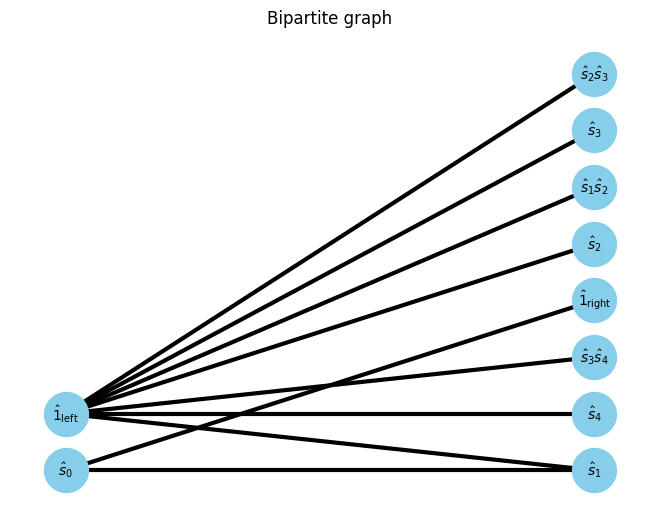

In [6]:
U, V, E, E_assigns = get_UVE(Hamiltonian, W_assigns, 0)
G, pos = show_bipartite(U, V, E)

Then, find maxmatching of the bipartite graph

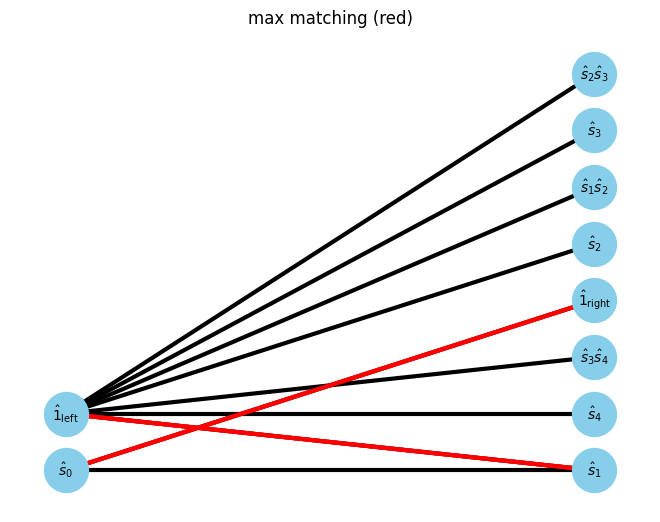

In [7]:
max_matching = show_maximal_matching(G, pos)

In bipartite graph, the minimum vertex cover (green vertex) can be found from the previous maxmatching.

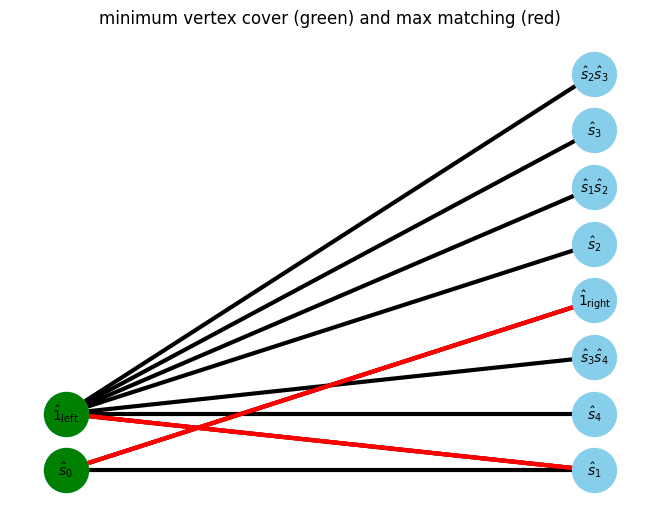

In [8]:
min_vertex_cover = show_min_vertex_cover(G, pos, max_matching)

For each minimum vertex covers,

1. if the vertex cover is in the left side, we can extract normal site operator.
   
2. if the vertex cover is in the right side, we can define the complementary operator connected to the vertex cover.

And then, we can assign normal and complementary operators to MPO.

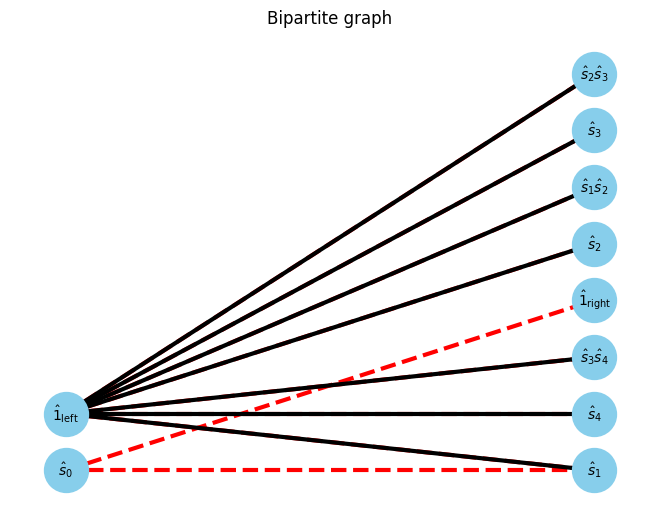

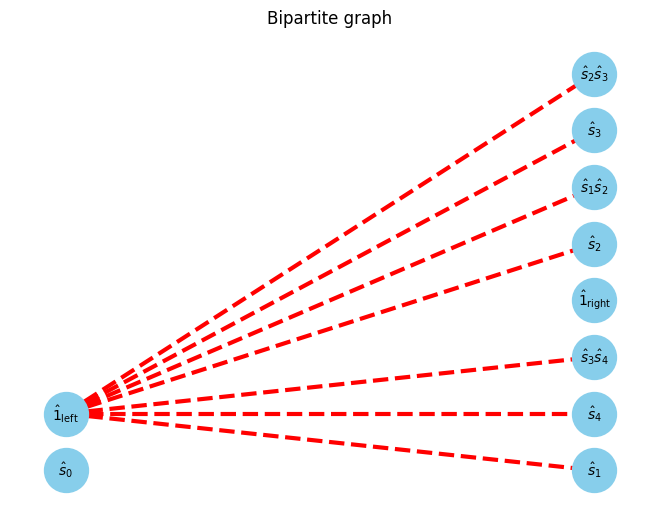

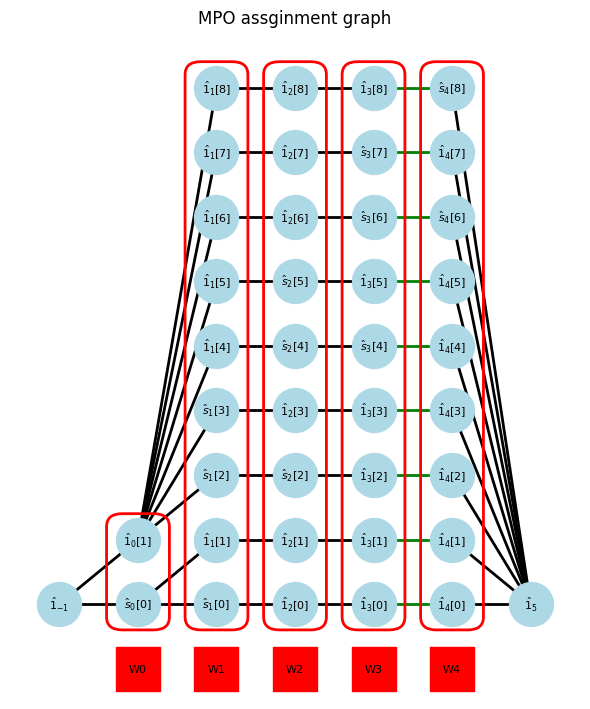

In [9]:
Unew, Wi = assign_core(
    min_vertex_cover=min_vertex_cover,
    U=U,
    V=V,
    E=E,
    operators=Hamiltonian,
    isite=0,
    W_assigns=W_assigns,
    E_assigns=E_assigns,
    coef_site=coef_site,
    visualize=True,
)

In [10]:
W.append(Wi)
display(*W)

Matrix([[\hat{s}_0, 1]])

Repeat the same procedure till the end of the MPO.

In [11]:
assign_core??

Signature:
assign_core(
    *,
    min_vertex_cover: list[str],
    U: list[str],
    V: list[str],
    E: list[tuple[str, str]],
    operators: pympo.operators.SumOfProducts,
    isite: int,
    W_assigns: list[list[int]],
    E_assigns: list[tuple[str, str]],
    coef_site: list[int],
    visualize: bool = True,
) -> tuple[list[str], sympy.matrices.dense.MutableDenseMatrix]
Docstring: <no docstring>
Source:   
def assign_core(
    *,
    min_vertex_cover: list[str],
    U: list[str],
    V: list[str],
    E: list[tuple[str, str]],
    operators: SumOfProducts,
    isite: int,
    W_assigns: list[list[int]],
    E_assigns: list[tuple[str, str]],
    coef_site: list[int],
    visualize: bool = True,
) -> tuple[list[str], sympy.Matrix]:
    Unew: list[str] = []  # U[1..i]
    unique_ops = []
    update_coef_ops = []
    for j, vertex in enumerate(min_vertex_cover):
        if vertex in U:
            Unew.append(vertex)
            # remove the edge connected to the vertex
            r

isite=1


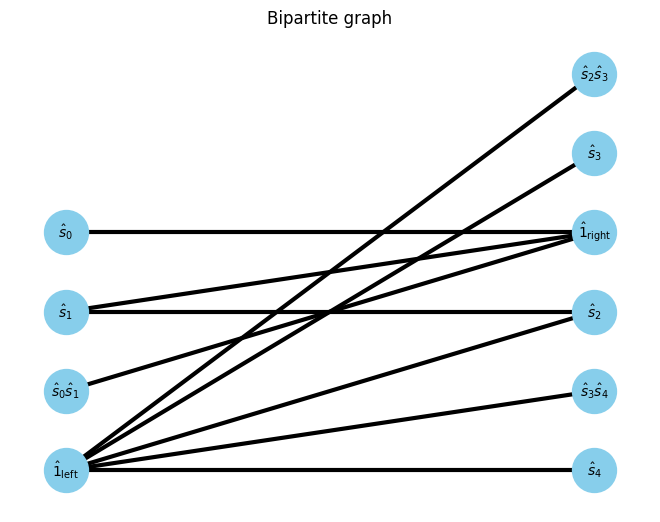

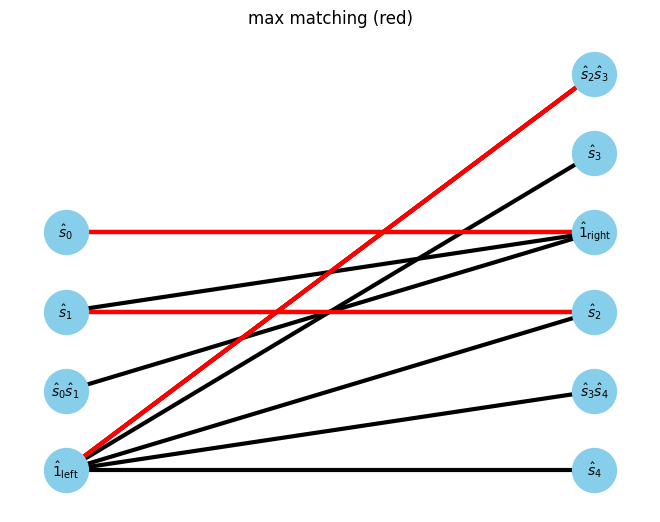

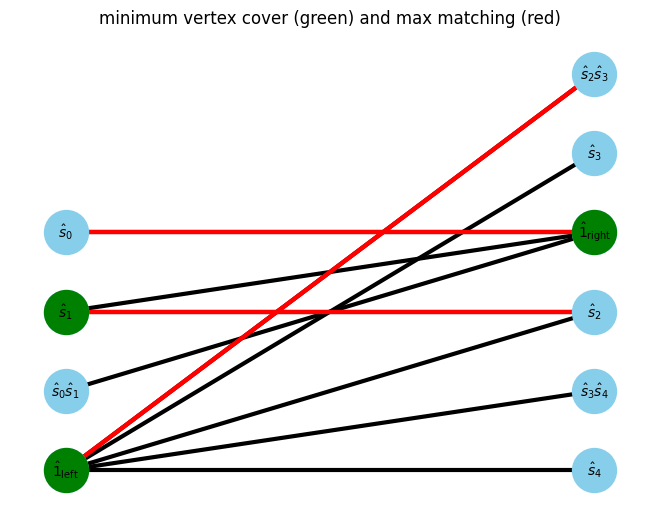

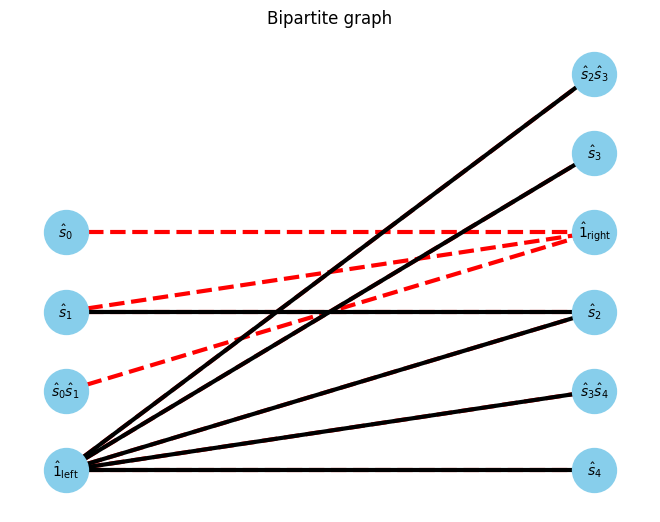

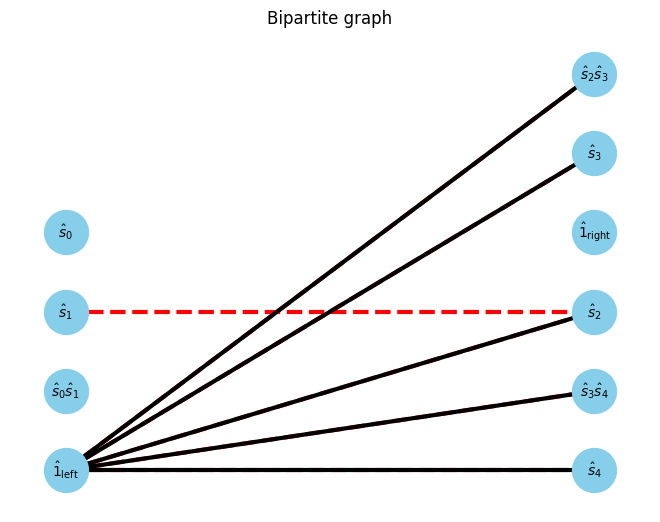

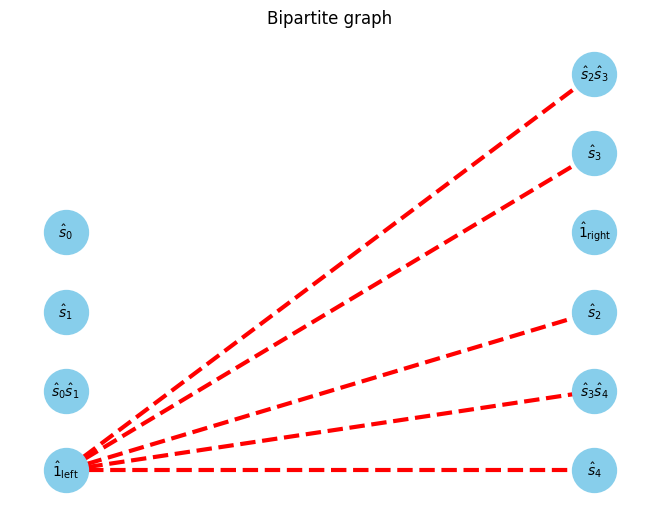

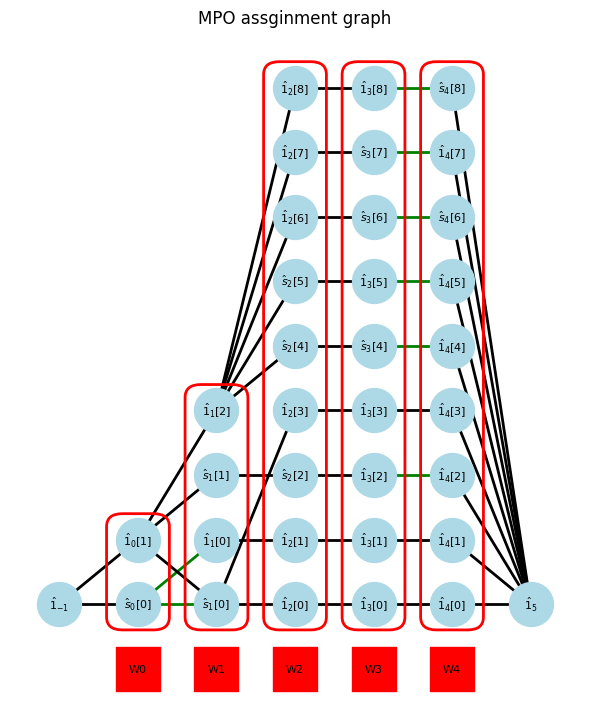

Matrix([[\hat{s}_0, 1]])

Matrix([
[-J*\hat{s}_1 - h,         0, 0],
[    -h*\hat{s}_1, \hat{s}_1, 1]])

W0 W1 =


Matrix([[-J*\hat{s}_0*\hat{s}_1 - h*\hat{s}_0 - h*\hat{s}_1, \hat{s}_1, 1]])

isite=2


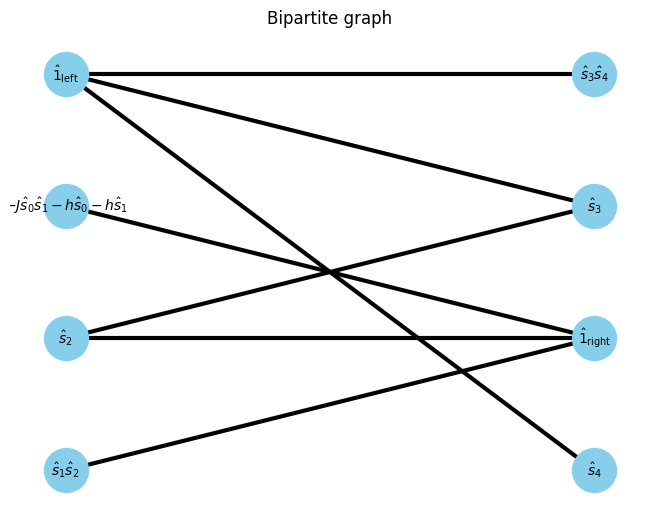

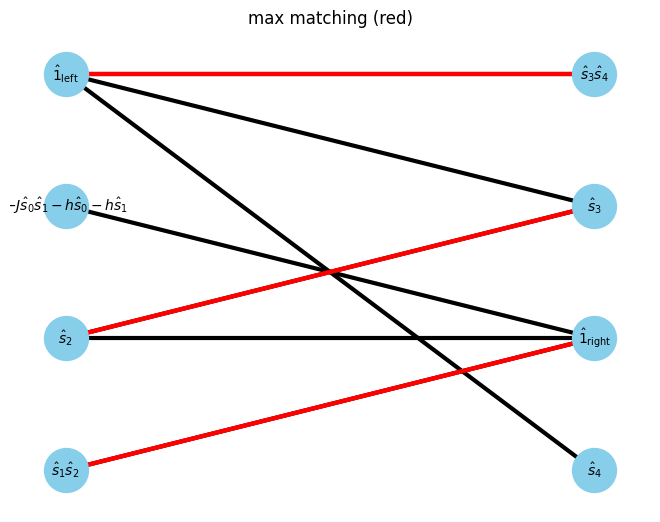

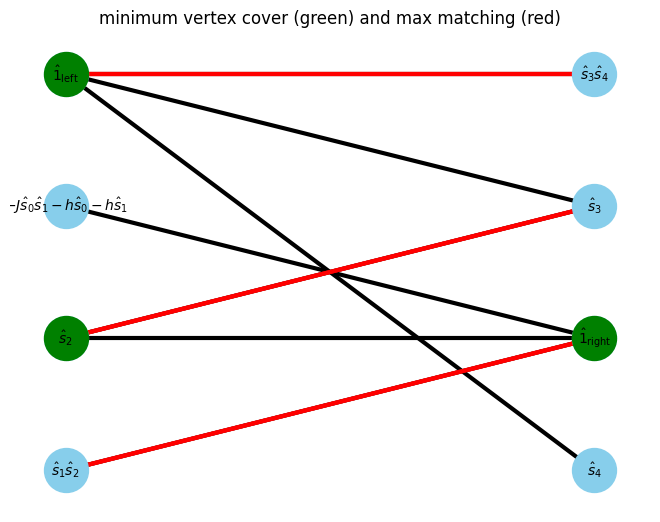

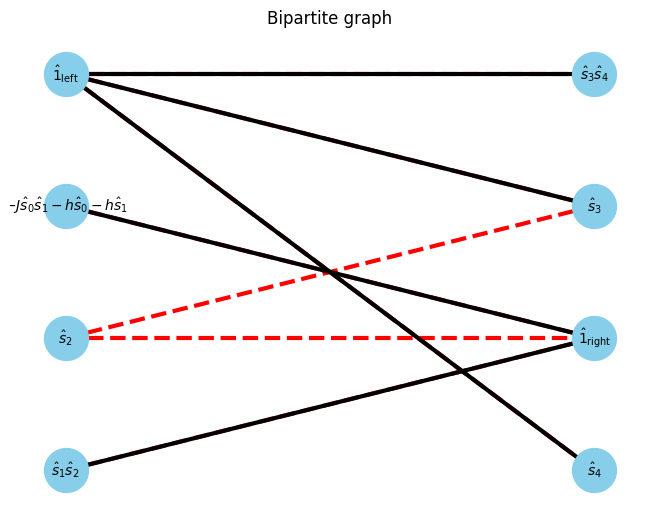

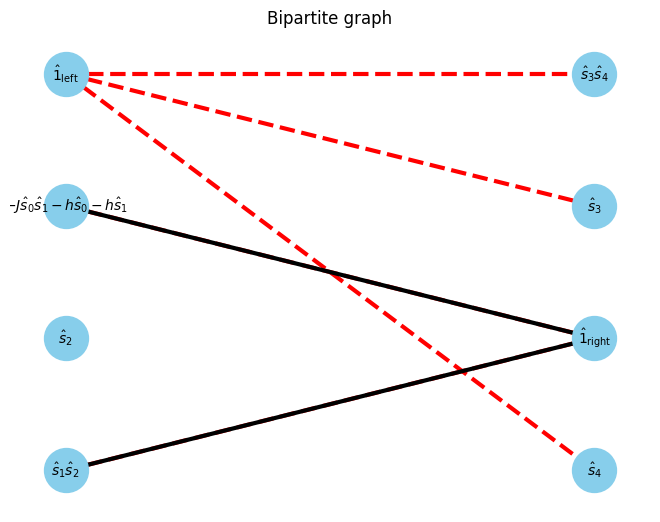

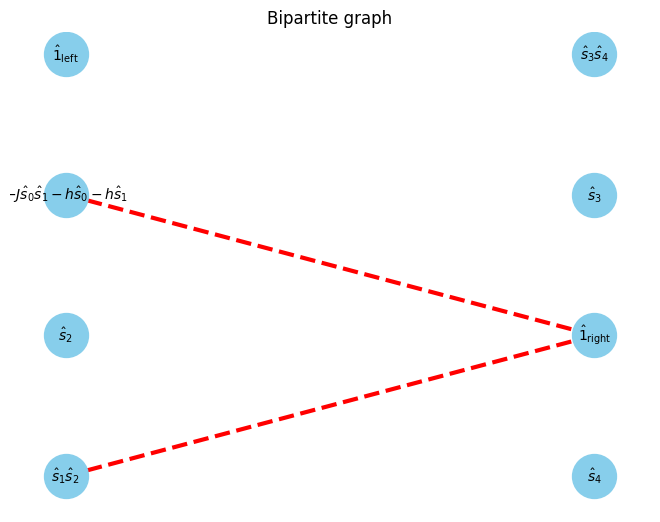

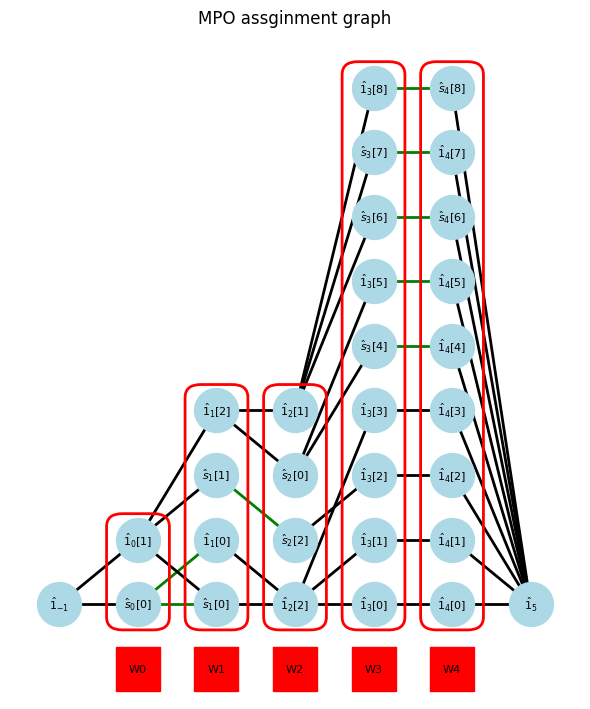

Matrix([[\hat{s}_0, 1]])

Matrix([
[-J*\hat{s}_1 - h,         0, 0],
[    -h*\hat{s}_1, \hat{s}_1, 1]])

Matrix([
[        0, 0,            1],
[        0, 0, -J*\hat{s}_2],
[\hat{s}_2, 1,            0]])

W0 W1 W2 =


Matrix([[\hat{s}_2, 1, -J*\hat{s}_0*\hat{s}_1 - J*\hat{s}_1*\hat{s}_2 - h*\hat{s}_0 - h*\hat{s}_1]])

isite=3


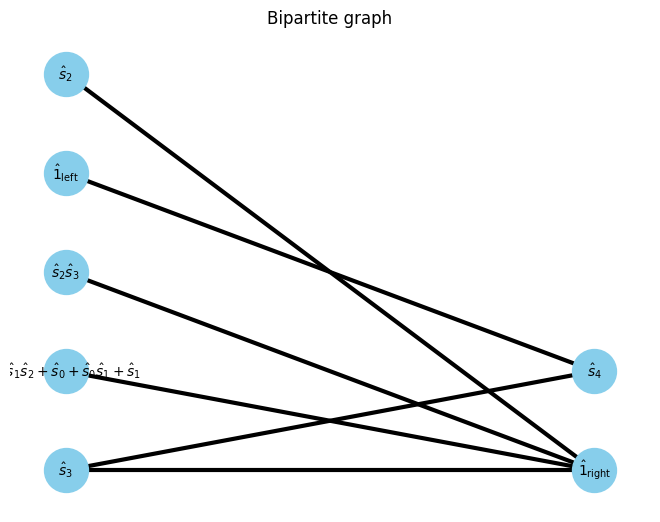

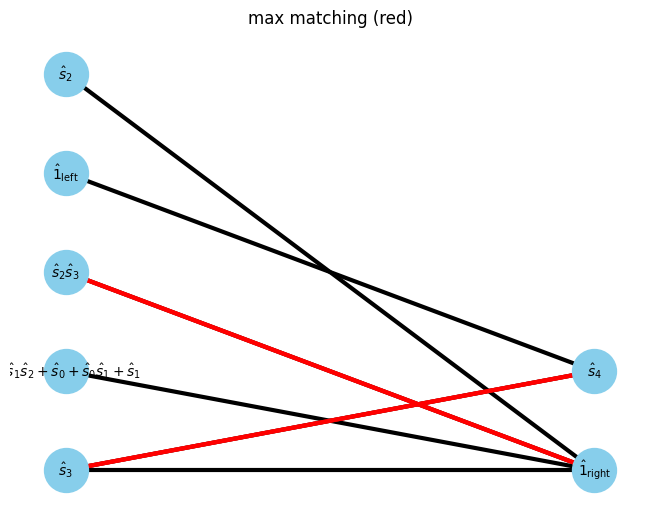

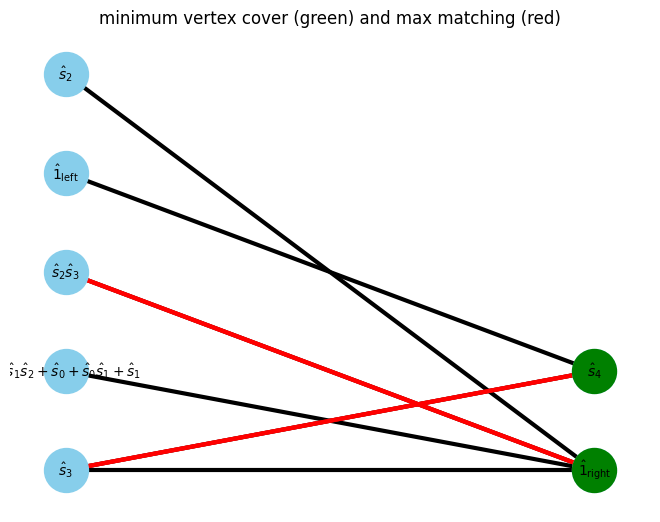

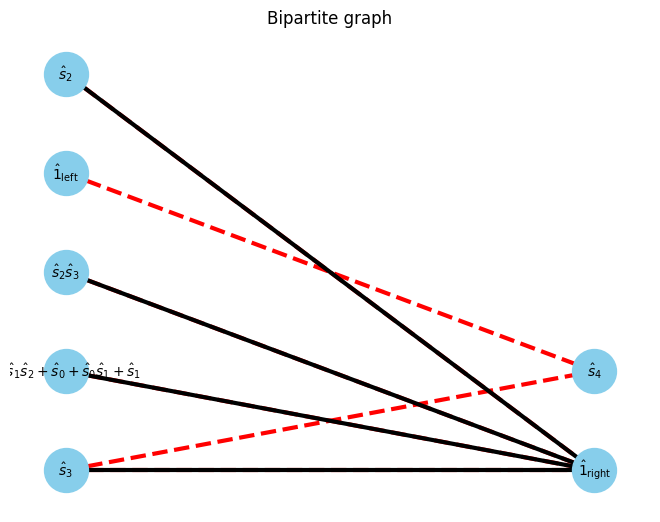

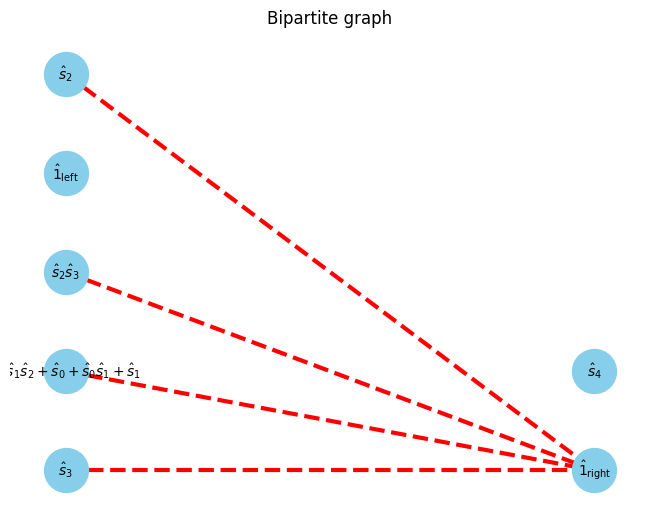

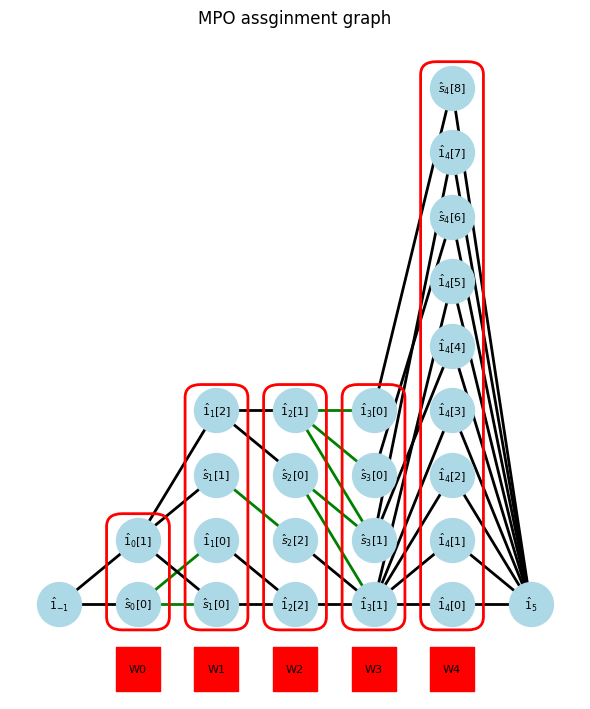

Matrix([[\hat{s}_0, 1]])

Matrix([
[-J*\hat{s}_1 - h,         0, 0],
[    -h*\hat{s}_1, \hat{s}_1, 1]])

Matrix([
[        0, 0,            1],
[        0, 0, -J*\hat{s}_2],
[\hat{s}_2, 1,            0]])

Matrix([
[               0, -J*\hat{s}_3 - h],
[-J*\hat{s}_3 - h,     -h*\hat{s}_3],
[               0,                1]])

W0 W1 W2 W3 =


Matrix([[-J*\hat{s}_3 - h, -J*\hat{s}_0*\hat{s}_1 - J*\hat{s}_1*\hat{s}_2 - J*\hat{s}_2*\hat{s}_3 - h*\hat{s}_0 - h*\hat{s}_1 - h*\hat{s}_2 - h*\hat{s}_3]])

isite=4


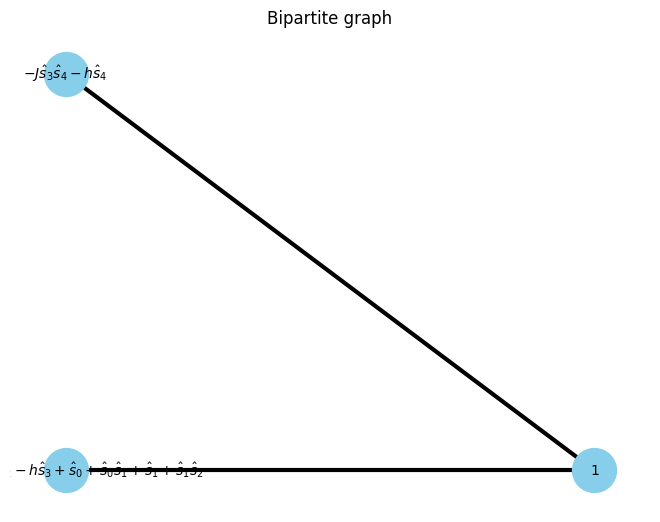

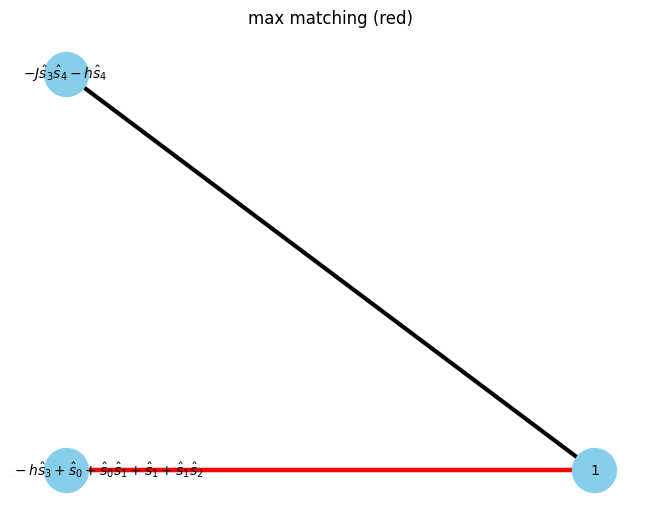

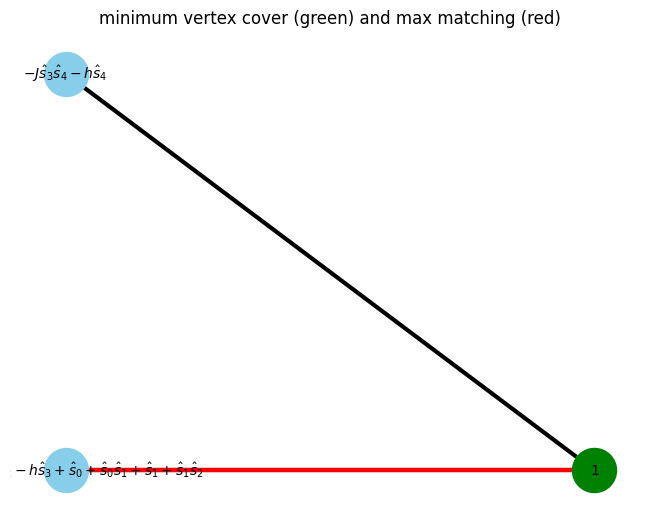

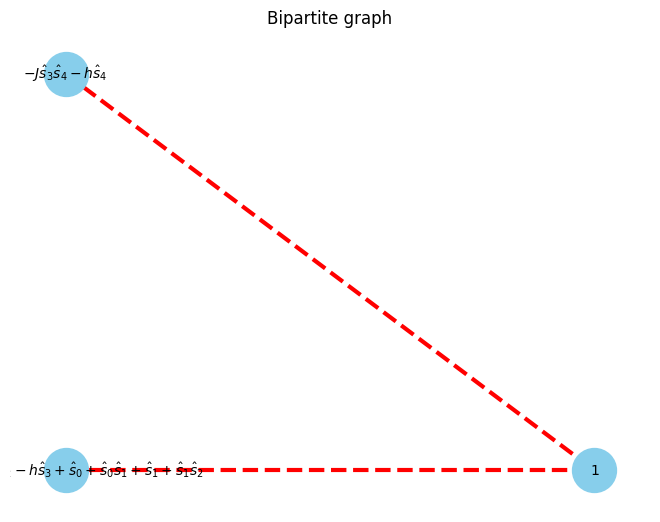

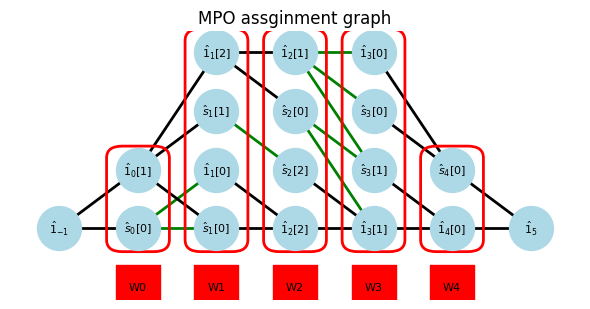

Matrix([[\hat{s}_0, 1]])

Matrix([
[-J*\hat{s}_1 - h,         0, 0],
[    -h*\hat{s}_1, \hat{s}_1, 1]])

Matrix([
[        0, 0,            1],
[        0, 0, -J*\hat{s}_2],
[\hat{s}_2, 1,            0]])

Matrix([
[               0, -J*\hat{s}_3 - h],
[-J*\hat{s}_3 - h,     -h*\hat{s}_3],
[               0,                1]])

Matrix([
[\hat{s}_4],
[        1]])

W0 W1 W2 W3 W4 =


Matrix([[-J*\hat{s}_0*\hat{s}_1 - J*\hat{s}_1*\hat{s}_2 - J*\hat{s}_2*\hat{s}_3 - J*\hat{s}_3*\hat{s}_4 - h*\hat{s}_0 - h*\hat{s}_1 - h*\hat{s}_2 - h*\hat{s}_3 - h*\hat{s}_4]])

In [12]:
for isite in range(1, Hamiltonian.ndim):
    print(f"{isite=}")
    U, V, E, E_assigns = get_UVE(Hamiltonian, W_assigns, isite, Unew)
    G, pos = show_bipartite(U, V, E)
    max_matching = show_maximal_matching(G, pos)
    min_vertex_cover = show_min_vertex_cover(G, pos, max_matching)
    Unew, Wi = assign_core(
        min_vertex_cover=min_vertex_cover,
        U=U,
        V=V,
        E=E,
        operators=Hamiltonian,
        isite=isite,
        W_assigns=W_assigns,
        E_assigns=E_assigns,
        coef_site=coef_site,
        visualize=True,
    )
    W.append(Wi)
    display(*W)
    W_prod = sympy.Mul(*W)
    print(*[f"W{i}" for i in range(isite + 1)], "=")
    display(W_prod.expand())